In [1]:
#Import essential libraries

import numpy as np
import math
import matplotlib.pylab as plb
from seaborn import *
# from tqdm import tqdm # Progress bar - pip install tqdm
from IPython.core.debugger import Tracer # for debugging

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Define Used Functions

def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
    
        
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])

In [3]:
def exponential_decay(initial_value, tau, current_step):
    return initial_value * math.exp(-current_step / tau )

In [4]:
def plot_centers(centers, size_k):
    # for visualization, you can use this:
    for i in range(1, size_k**2 + 1):
        plb.subplot(size_k,size_k,i)
        
        plb.imshow(np.reshape(centers[i-1,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')
        
    plb.show()

In [5]:
def kohonen(**kwarg):
    """Example for using create_data, plot_data and som_step.
    Accepted **kwarg(s):
    (int) size - size of the Kohonen map
    (float) learning_rate - initial learning rate
    (int) maxiter - maximum number of iterations
    (float) sigma - initial width of neighborhood
    (int) neighborhood_decay_tau - neighborhood decay time constant
    (int) learning_decay_tau - learning rate decay time constant
    """
    plb.close('all')
    
    dim = 28*28
    data_range = 255.0
    
    # load in data and labels    
    data = np.array(np.loadtxt('data.txt'))
    labels = np.array(np.loadtxt('labels.txt'))

    # select 4 digits    
    name = 'Mateusz Paluchowski' # REPLACE BY YOUR OWN NAME
    targetdigits = name2digits(name) # assign the four digits that should be used
    # this selects all data vectors that corresponds to one of the four digits
    labeled_data = np.hstack((np.array([labels]).T, data))
    selected_labeled_data = labeled_data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    labels, data = np.split(selected_labeled_data, [1], axis=1)
    
    dy, dx = data.shape
        
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = kwarg.get('size') if kwarg.get('size') else 6 # default: 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = kwarg.get('sig') if kwarg.get('sig') else 2.0 # default: 2.0
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    eta = kwarg.get('learning_rate') if kwarg.get('learning_rate') else 0.9 # default: 0.9 HERE YOU HAVE TO SET YOUR OWN LEARNING RATE
    
    #set the maximal iteration count
    tmax = kwarg.get('maxiter') if kwarg.get('maxiter') else 5000 # default: 5000 this might or might not work; use your own convergence criterion
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    
    current_iter = 0
    initial_sigma = sigma
    initial_eta = eta
    for t, i in enumerate(i_random):
        old_centers = np.copy(centers)
        
        if kwarg.get('neighborhood_decay_tau'):
            sigma =  exponential_decay(initial_sigma, kwarg.get('neighborhood_decay_tau'), current_iter)
            
        if kwarg.get('learning_decay_tau'):
            eta =  exponential_decay(initial_eta, kwarg.get('learning_decay_tau'), current_iter)
            
        som_step(centers, data[i,:], neighbor, eta, sigma)
        
        label = labels[i,:]
        
        if current_iter%1000 == 0 and kwarg.get('show_cluster_change'):
            print(np.sum(abs(centers - old_centers)) / np.sum(abs(old_centers)))        
#         if np.sum(abs(centers - old_centers)) / np.sum(abs(old_centers)) < 0.04: 
#             print('Elapsed iterations: ', current_iter)
#             break
        current_iter += 1
    if(kwarg.get('show_cluster_change')):
        print(np.sum(abs(centers - old_centers)) / np.sum(abs(old_centers)))
    plot_centers(centers, size_k)
    
    assignments = knn_assignments(centers, data, labels, n=3) #Our function: get_assignments(centers, data, labels)
    print_assignments(assignments)

In [6]:
def get_assignments(centers, data, labels):
    """Does an assignment of each prototype in the network, by assigning with each prototype the class
    of the closest example from the data. 
    
    assignments = get_assignments(centers, cata)
    
    Input and output arguments:
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (matric) the matrix containing all the examples (datapoints)
       
       labels   (vector) the vector containing the class of each data sample
    """
    # N is the number of datapoints
    n = data.shape[0]
    
    # d is the number of features
    d = data.shape[1]
    
    assignments = []
    
    print('data:', data.shape)
    print('centers:', centers.shape)
    
    
    assignments = []
    for proto in centers:
        distances = np.sum(abs(data - proto), axis=1)
        
        ind = np.argmin(distances)
        label = labels[ind] 
        assignments.append(label)
        
    return assignments

In [7]:
def print_assignments(assignments):
    # Transform the n * 1 vector (n is number of neurons) 
    # into a k * k metrix for visualization
    
    k = int(np.sqrt(len(assignments)))
    
    print('Assignments:')
    print(np.reshape(assignments, (k,k)))

In [8]:
from sklearn.neighbors import KNeighborsClassifier

def knn_assignments(centers, data, labels, n):
    """ Assigns a label to each center by applying the KNN-algorithm on the training data. 
    
    assignments = get_assignments(centers, data, labels, n=3)
    
    Input and output arguments:
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (matric) the matrix containing all the examples (datapoints)
       
       labels   (vector) the vector containing the class of each data sample
       
       n        (int) the number of neighbours to take into account
    """
    
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(data, np.ravel(labels)) 
    
    return [neigh.predict(np.reshape(proto, (1,-1))) for proto in centers]

Set we will be using for training:

In [9]:
name = 'Mateusz Paluchowski'
name2digits(name)

array([3, 5, 6, 8], dtype=uint8)

Default parameters test:

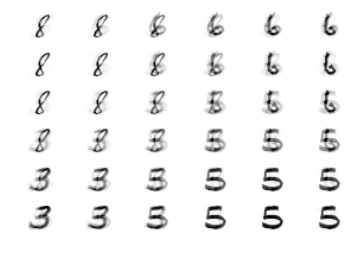

Assignments:
[[ 8.  8.  6.  6.  6.  6.]
 [ 8.  8.  8.  6.  6.  6.]
 [ 8.  8.  8.  6.  6.  6.]
 [ 8.  8.  3.  5.  5.  5.]
 [ 3.  3.  3.  5.  5.  5.]
 [ 3.  3.  3.  5.  5.  5.]]


In [10]:
kohonen(maxiter=19000)

___

Start with a Kohonen network of 6x6 neurons that are arranged on a square grid
with unit distance and use a Gaussian neighborhood function with (constant)
standard deviation σ = 3. Implement the Kohonen algorithm and apply it to the
data in data.txt. Choose a small (constant) learning rate and report how you
decide when your algorithm has converged.

    As described in Haykin as a general rule, the number of iterations constituting the convergence phase must be at least 500 times the number of neurons in the network + 1000 iteration for oredering phase.

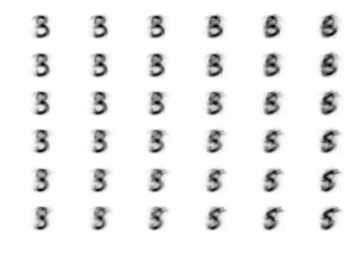

Assignments:
[[ 3.  3.  3.  5.  5.  5.]
 [ 3.  3.  3.  3.  5.  5.]
 [ 3.  3.  3.  3.  5.  5.]
 [ 3.  3.  3.  3.  5.  5.]
 [ 3.  3.  3.  3.  5.  5.]
 [ 3.  3.  3.  8.  5.  5.]]


In [11]:
maximum_iterations = 6*6*500+1000 # 19k
kohonen(size=6, sig=3.0, learning_rate=0.1, maxiter=maximum_iterations)

____________________

Explore different sizes of the Kohonen map (try at least 3 different sizes, not less
than 36 units). Explore different widths of the neighborhood function (try at least
σ = 1, 3, and 5). Describe the role of the width of the neighborhood function.
Does the optimal width depend on the size of the Kohonen map?

### 8x8, sig=3

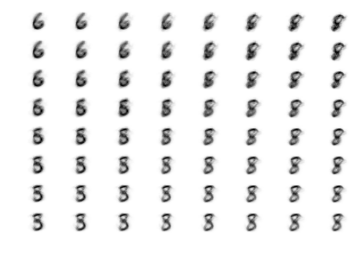

Assignments:
[[ 6.  6.  6.  6.  6.  6.  5.  8.]
 [ 6.  6.  6.  6.  6.  8.  8.  8.]
 [ 6.  6.  6.  6.  6.  8.  8.  8.]
 [ 6.  6.  5.  5.  5.  8.  8.  8.]
 [ 5.  5.  5.  5.  8.  8.  8.  8.]
 [ 5.  3.  3.  8.  8.  8.  8.  8.]
 [ 3.  3.  3.  3.  3.  8.  8.  8.]
 [ 3.  3.  3.  3.  3.  3.  8.  8.]]


In [12]:
maximum_iterations = 8*8*500+1000 # 33k
kohonen(size=8, sig=3.0, learning_rate=0.1, maxiter=maximum_iterations)

### 10x10, sig=3

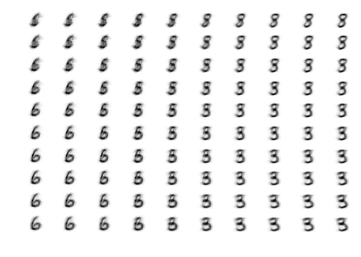

Assignments:
[[ 6.  6.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 6.  6.  6.  8.  3.  3.  5.  5.  8.  8.]
 [ 6.  6.  6.  5.  5.  5.  3.  3.  3.  3.]
 [ 6.  6.  5.  5.  5.  3.  3.  3.  3.  3.]
 [ 6.  6.  5.  5.  5.  3.  3.  3.  3.  3.]
 [ 6.  6.  5.  5.  5.  3.  3.  3.  3.  3.]
 [ 6.  6.  6.  5.  5.  5.  3.  3.  3.  3.]
 [ 6.  6.  6.  5.  5.  5.  3.  3.  3.  3.]
 [ 6.  6.  6.  5.  5.  5.  3.  3.  3.  3.]
 [ 6.  6.  6.  6.  5.  3.  3.  3.  3.  3.]]


In [13]:
maximum_iterations = 10*10*500+1000 # 51k
kohonen(size=10, sig=3.0, learning_rate=0.1, maxiter=maximum_iterations)

### 12x12, sig=3

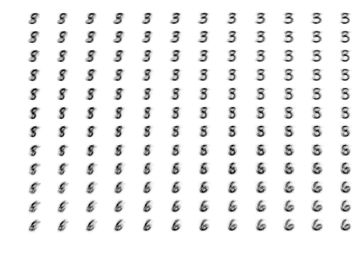

Assignments:
[[ 8.  8.  8.  5.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 8.  8.  8.  5.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 8.  8.  8.  5.  5.  3.  3.  3.  3.  3.  3.  3.]
 [ 8.  8.  8.  5.  5.  3.  3.  3.  3.  3.  3.  3.]
 [ 8.  8.  5.  5.  5.  3.  3.  3.  3.  3.  3.  3.]
 [ 8.  8.  8.  8.  8.  3.  3.  3.  3.  3.  3.  5.]
 [ 5.  5.  8.  8.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 8.  8.  8.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 8.  8.  5.  6.  6.  6.  6.  5.  5.  5.  6.  6.]
 [ 8.  8.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [ 5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [ 5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]]


In [14]:
maximum_iterations = 12*12*500+1000 # 73k
kohonen(size=12, sig=3.0, learning_rate=0.1, maxiter=maximum_iterations)

### 8x8, sig=1

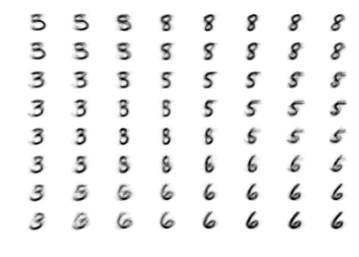

Assignments:
[[ 3.  5.  3.  8.  8.  8.  8.  8.]
 [ 3.  3.  5.  5.  5.  8.  8.  8.]
 [ 3.  3.  3.  5.  5.  5.  5.  8.]
 [ 3.  3.  3.  3.  5.  5.  5.  5.]
 [ 3.  3.  3.  3.  5.  6.  5.  5.]
 [ 3.  3.  3.  5.  6.  6.  6.  6.]
 [ 3.  5.  6.  6.  6.  6.  6.  6.]
 [ 3.  6.  6.  6.  6.  6.  6.  6.]]


In [15]:
maximum_iterations = 8*8*500+1000 # 33k
kohonen(size=8, sig=1.0, learning_rate=0.1, maxiter=maximum_iterations)

### 8x8, sig=5

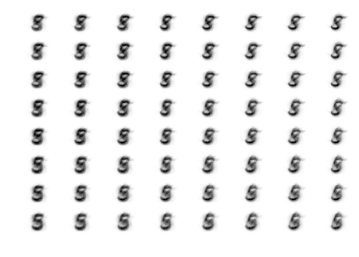

Assignments:
[[ 8.  8.  8.  8.  8.  5.  5.  5.]
 [ 8.  8.  8.  8.  8.  5.  5.  5.]
 [ 8.  8.  8.  8.  8.  5.  5.  5.]
 [ 8.  8.  8.  8.  8.  5.  5.  5.]
 [ 8.  5.  5.  8.  8.  8.  8.  5.]
 [ 5.  5.  5.  5.  8.  8.  8.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]]


In [16]:
maximum_iterations = 8*8*500+1000 # 33k
kohonen(size=8, sig=5.0, learning_rate=0.1, maxiter=maximum_iterations)

___

Until now, the width of the neighborhood function has been constant. Now, start
with a large σ and decrease it over the runtime of the algorithm. Does it improve
your result?

    Just as Haykin proposed, we set the time constant of our neighborhood decay using following formula:
$$\tau = \frac{1000}{\log{\sigma}}$$
    where sigma is 'radius' of the map and equals:
$$\sigma = \sqrt{3^2 + 3^2} \approx 4.24$$

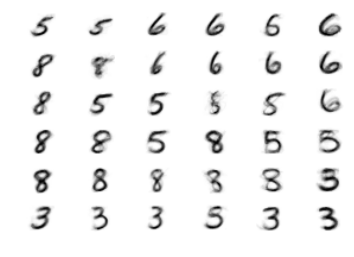

Assignments:
[[ 5.  5.  6.  6.  6.  6.]
 [ 8.  8.  6.  6.  6.  6.]
 [ 8.  5.  5.  5.  5.  6.]
 [ 8.  8.  5.  8.  5.  3.]
 [ 8.  8.  8.  3.  8.  5.]
 [ 3.  3.  3.  5.  3.  3.]]


In [17]:
tau = 1000 / math.log(4.24)
maximum_iterations = 6*6*500+1000 # 19k
kohonen(size=6, sig=4.24, learning_rate=0.1, maxiter=maximum_iterations, neighborhood_decay_tau=tau)

___

### Bonus: Let's test influence of exponential decay of learning rate

Since exponential decay of learning rate is given by the following formula:
$$\eta(n) = \eta^{}_{0} \exp{(\frac{-n}{\tau^{}_{2}})}$$
where
$\eta^{}_{0}$ should be no larger than 0.1 and $\eta(n)$ should be no smaller than 0.01 we end up with:
$$\tau^{}_{2} \approx 8252 $$

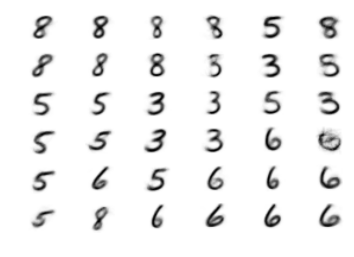

Assignments:
[[ 8.  8.  8.  8.  5.  8.]
 [ 8.  8.  8.  3.  3.  5.]
 [ 5.  5.  3.  3.  5.  3.]
 [ 5.  5.  3.  3.  6.  6.]
 [ 5.  6.  5.  6.  6.  6.]
 [ 5.  8.  6.  6.  6.  6.]]


In [18]:
tau = 1000 / math.log(4.24)
maximum_iterations = 6*6*500+1000 # 19k
tau2 = 8252
kohonen(size=6, \
        sig=4.24, \
        learning_rate=0.1, \
        maxiter=maximum_iterations, \
        neighborhood_decay_tau=tau, \
        learning_decay_tau=tau2)

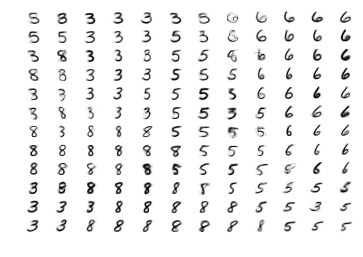

Assignments:
[[ 5.  8.  3.  3.  3.  3.  5.  6.  6.  6.  6.  6.]
 [ 5.  5.  3.  3.  3.  5.  3.  6.  6.  6.  6.  6.]
 [ 3.  8.  3.  3.  3.  5.  5.  8.  6.  6.  6.  6.]
 [ 8.  8.  3.  3.  3.  5.  5.  5.  6.  6.  6.  6.]
 [ 3.  3.  3.  3.  5.  5.  5.  5.  6.  6.  6.  6.]
 [ 3.  8.  3.  3.  3.  5.  5.  3.  5.  6.  6.  6.]
 [ 8.  3.  8.  8.  8.  5.  5.  5.  5.  6.  6.  6.]
 [ 8.  8.  8.  8.  8.  8.  5.  5.  5.  6.  6.  6.]
 [ 8.  8.  8.  8.  8.  8.  5.  5.  5.  8.  6.  6.]
 [ 3.  8.  8.  8.  8.  8.  5.  5.  5.  5.  5.  5.]
 [ 3.  3.  3.  8.  8.  8.  8.  8.  5.  5.  3.  5.]
 [ 3.  3.  8.  8.  8.  8.  8.  8.  8.  5.  5.  5.]]


In [20]:
tau = 1000 / math.log(8.45)
maximum_iterations = 12*12*500+1000 # 73k
tau2 = 13703
kohonen(size=12, \
        sig=8.45, \
        learning_rate=0.1, \
        maxiter=maximum_iterations, \
        neighborhood_decay_tau=tau, \
        learning_decay_tau=tau2)